Getting in the right mindset: separating Settings from Events
-------------

One conceptual hurdle that one must overcome when building
a diabetes data model is to separate *events* (or *actions*) from *user settings*. For example,
an **action** is when you deliver 2 units of insulin, or eat 30 g of sugar. A **setting**
is e.g. your body's insulin sensitivity, and here is the key: there exists a *true* "setting" or
your body's actual response to the insulin, and also a *user setting* or what you and your
BolusWizard calculator *thinks* your body's response will be.

Why is this distinction important? Well, when took the two actions of eating 30 g of sugar
and giving yourself 2 units of insulin, you've made two assumptions about your body's
response (or settings): your body's response to the food, and your body's response to the
insulin. (The ratio of these responses, of course, is the insulin-to-carb ratio that you set
in your BolusWizard settings.) But in order to test different insulin-to-carb ratio hypotheses,
and find your body's *true* response to insulin and food, we must separate the events from the settings.

One note on why we will not focus on the insulin-to-carb ratio, and instead seek to understand
your body's reponse individually to food and insulin: your body's response to food/insulin are the
fundamental quantities here. If you eat food but give no insulin, your body will respond to the food
regardless of what's happening with the insulin. The same happens when you give insulin but eat no
food. So we can build better predictions of these types of events (insulin+food, insulin only, food only,
and everything in between) if we focus on the body's response to food and insulin, rather than the ratio.
The response to insulin you know as **"sensitivity" (expressed in (mg/dL)/u)**, and the response to food
we will call **"food sensitivity" (expressed in (mg/dL)/g)** -- they are the blood sugar response to insulin
and food individually.

In [1]:
import sys
sys.path.insert(0, "../")
from BGModel.BGActionClasses import *

Events in the BGModel - *independent* of settings
--------
Let's see how we express some events in the data model. They either have a time associated with them, or a time interval (an "interval of validity"). We have BG measurements, insulin boluses, square wave boluses, dual-wave boluses, and food:

In [2]:
measurement = BGMeasurement.FromStringDate('2019-02-24T12:00:00','2019-02-24T12:45:00',172)

insulin = InsulinBolus.FromStringDate('2019-02-24T09:00:00',2.0)

swb = SquareWaveBolus.FromStringDate('2019-02-24T12:00:00',3,2.0)

dwb = DualWaveBolus.FromStringDate('2019-02-24T12:00:00',3,2.0,2.0) # hours first, then insulin.

food = Food.FromStringDate('2019-02-24T12:00:00',30)

Settings in the BGModel: your body's response to food/carb input
----------
The events above did not need settings to initialize them, but of course in order to calculate your body's response to them, you will need to make some assumptions about your body's response (or settings). So let's see how we set up our settings class. We'll start with an individual setting, your insulin sensitivity ($S_\text{insulin}$). We make the setting, and then initiate a "snapshot" of that setting. (We make "snapshots" possible so that we can store multiple settings snapshots, e.g. to store the history of the settings in your BolusWizard). If you don't need to worry about your BolusWizard history, then one snapshot will suffice.

### Adding the insulin sensitivity setting:

In [3]:
import BGModel.Settings as Settings

settings_sensitivity = Settings.UserSetting('Sensitivity')
the_time = '2019-02-24 00:00:00' # the time at which this setting started being used.
settings_sensitivity.getOrMakeSettingsSnapshot(the_time)
settings_sensitivity.AddSettingToSnapshot(the_time,0,60) # 60 mg/dL / u starting at midnight
settings_sensitivity.AddSettingToSnapshot(the_time,12,50) # 50 mg/dL / u starting at 12pm
settings_sensitivity.AddSettingToSnapshot(the_time,18,40) # 40 mg/dL / u starting at 6pm

print(settings_sensitivity.latestSettingsSnapshot().dtype)
print(settings_sensitivity.latestSettingsSnapshot()) # the times are in seconds (from Midnight)

[('time', '<m8[s]'), ('value', '<f8')]
[(    0, 60.) (43200, 50.) (64800, 40.)]


The settings are stored as 2-dimensional tuples: timedelta objects is
[0] or ['time'] and the value of the setting is [1] or ['value'].

### Carb sensitivity: Adding the carb-insulin ratio setting, and a note:

Now you add your carb-to-insulin ratio setting, $R_\text{carb-insulin}$. *Note: this is not a
fundamental quantity! But since every insulin pump uses this value, and users are more familiar with it we
use it here too.* Later we derive the fundamental quantity "carb sensitivity"
by using the simple formula

$$S_\text{carb} = \frac{S_\text{insulin}}{R_\text{carb-insulin}}$$

The eventual goal would be for insulin users to understand that "carb sensitivity" (your body's
response to food) is the more fundamental quantity, and an important one! For example, your blood sugar
is 50 mg/dL, and you want to get it to 125. You can't calculate this from $R_\text{carb-insulin}$ alone - you
need to know $S_\text{carb}$!

In [4]:
settings_ric = Settings.UserSetting('RIC')
settings_ric.getOrMakeSettingsSnapshot(the_time)
settings_ric.AddSettingToSnapshot(the_time,0,15) # insulin-carb ratio of 15 g / (mg/dL)

print(settings_ric.latestSettingsSnapshot()) # the times are in seconds (from Midnight)

[(0, 15.)]


### Adding the insulin duration setting:

By now you get the idea. Add the setting for insulin duration (the decay time of your insulin). This quantity is of course important for calculating the duration of actions involving insulin:

In [5]:
settings_duration = Settings.UserSetting('Duration')
settings_duration.getOrMakeSettingsSnapshot(the_time)

settings_duration.AddSettingToSnapshot(the_time,0,3.0)

### Getting at the Basal Glucose: adding the basal insulin setting

Your body produces its own basal glucose (let's call it $G_\text{liver}$, in mg/dL / hour) -- this is a direct property of your body! Of course,
insulin users typically don't keep track of this quantity, but instead they concern themselves with
the indirect quantity, which is the basal insulin $I_\text{Basal}$ (in mg/dL / hour) they use to counteract that basal glucose. They are related
via:

$$G_\text{liver} = - I_\text{Basal} \times S_\text{insulin}$$

but of course, as with $S_\text{carb}$, $G_\text{liver}$ is the fundamental quantity. (Your blood sugar will rise indefinitely, whether or not you are delivering your basal insulin rate.)

But alas, users will have a setting corresponding to their basal insulin rate, which we will need to calculate that more fundamental quantity later:

In [6]:
settings_basal = Settings.UserSetting('Basal')
settings_basal.getOrMakeSettingsSnapshot(the_time)
settings_basal.AddSettingToSnapshot(the_time,0,1.0)
settings_basal.AddSettingToSnapshot(the_time,5,1.0)
settings_basal.AddSettingToSnapshot(the_time,12,2.0)
settings_basal.AddSettingToSnapshot(the_time,6,1.0)
settings_basal.AddSettingToSnapshot(the_time,18,1.0)

print(settings_basal.latestSettingsSnapshot())
print('Setting at midnight:',settings_basal.GetLatestSettingAtTime(0))

[(    0, 1.) (18000, 1.) (21600, 1.) (43200, 2.) (64800, 1.)]
Setting at midnight: 1.0


### Building a complete user profile: "TrueUserProfile"

Now that we have created all of our individual settings, do we have a full user profile? No, because like I said before, many of the quantities above are not the fundamental quantities, but indirect quantities like the insulin-carb-ratio and the basal insulin settings.

To get at the true user profile, with the fundamental quantities, we feed this into the "TrueUserProfile" class:

In [7]:
the_userprofile = Settings.TrueUserProfile()

the_userprofile.AddSensitivityFromArrays(settings_sensitivity.latestSettingsSnapshot(),
                                         settings_ric.latestSettingsSnapshot())

the_userprofile.AddHourlyGlucoseFromArrays(settings_basal.latestSettingsSnapshot(),
                                           settings_duration.latestSettingsSnapshot())
the_userprofile.Print()

Time                           :     12am        ____         4am        ____         8am        ____         12pm        ____         4pm        ____         8pm        ____
InsulinSensitivity Si (mgdL/u) :     -60   -60   -60   -50   -50   -40   -40   -40   -40   -40   -40   -40   -40   -40   -40   -40   -40   -40   -40   -40   -40   -40   -40   -40
                                     -60   -60   -60   -50   -40   -40   -40   -40   -40   -40   -40   -40   -40   -40   -40   -40   -40   -40   -40   -40   -40   -40   -40   -40
FoodSensitivity Sf (mgdL/g)    :     4.0   4.0   4.0   3.3   3.3   2.7   2.7   2.7   2.7   2.7   2.7   2.7   2.7   2.7   2.7   2.7   2.7   2.7   2.7   2.7   2.7   2.7   2.7   2.7
                                     4.0   4.0   4.0   3.3   2.7   2.7   2.7   2.7   2.7   2.7   2.7   2.7   2.7   2.7   2.7   2.7   2.7   2.7   2.7   2.7   2.7   2.7   2.7   2.7
(Carb ratio Si/Sf) (g/u)       :      15    15    15    15    15    15    15    15    15    15    15    15   

In [8]:
import time
struct_time = time.strptime('2019-02-24 13:01:00', "%Y-%m-%d %H:%M:%S")
utc_time = time.mktime(struct_time)
the_userprofile.getInsulinSensitivity(utc_time)

-40.0

Events in the BGModel that are *dependent* on settings
--------
Something.

### The Basal Insulin, and related Events

In [9]:
liver_glucose = LiverBasalGlucose()
basal = BasalInsulin.FromStringDate('2019-02-23T00:00:00','2019-02-25T23:59:59',
                                    settings_basal.latestSettingsSnapshot(),
                                    settings_sensitivity.latestSettingsSnapshot())
print(basal.BasalRates)

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 2.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


Something else, something else.

In [10]:
temp_basal = TempBasal.FromStringDate('2019-02-24T00:00:00','2019-02-24T23:59:59',1.2)
suspend = Suspend.FromStringDate('2019-02-24T05:00:00','2019-02-24T06:00:00')

Now to the plotting.

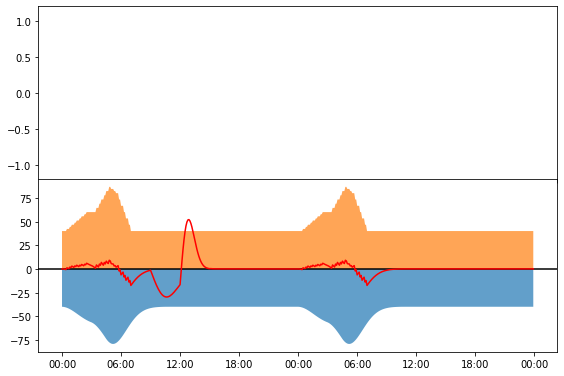

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Change figure defaults
plt.rcParams['figure.figsize'] = [9.0,6.0]

fig = plt.figure()
ax1 = fig.add_axes([0.1, 0.5, 0.8, 0.4],xticklabels=[], ylim=(-1.2, 1.2))
ax2 = fig.add_axes([0.1, 0.1, 0.8, 0.4]) #,ylim=(-200, 200)

utc_time = time.mktime(time.strptime(the_time, "%Y-%m-%d %H:%M:%S"))
x_times = range(int(utc_time),int(utc_time+48*3600),int(0.1*3600))
x_times_datetime = list(datetime.datetime.fromtimestamp(a) for a in x_times)
y_basalrates = np.array(list(basal.getBGEffectDerivPerHour(time_ut,the_userprofile) for time_ut in x_times))
y_liver = np.array(list(liver_glucose.getBGEffectDerivPerHour(time_ut,the_userprofile) for time_ut in x_times))
y_bolus = np.array(list(insulin.getBGEffectDerivPerHour(time_ut,the_userprofile) for time_ut in x_times))
y_food = np.array(list(food.getBGEffectDerivPerHour(time_ut,the_userprofile) for time_ut in x_times))

ax2.fill_between(x_times_datetime,0,y_basalrates,alpha=0.7)
#ax2.fill_between(x_times_datetime,y_basalrates,(y_basalrates+y_bolus))

ax2.fill_between(x_times_datetime,0,y_liver,alpha=0.7)
#ax2.fill_between(x_times_datetime,y_liver,y_liver+y_food)

ax2.axhline(0,c='black')

ax2.plot(x_times_datetime,y_basalrates+y_liver+y_food+y_bolus,color='red')

ax2.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))